In [51]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import matplotlib.ticker as ticker
torch.manual_seed(125)

In [52]:
def sin(x):
    if isinstance(x, torch.Tensor):
        return torch.sin(x)
    else:
        return 

def cos(x):
    if isinstance(x, torch.Tensor):
        return torch.cos(x)
    else:
        return np.cos(x)

## Generate training data

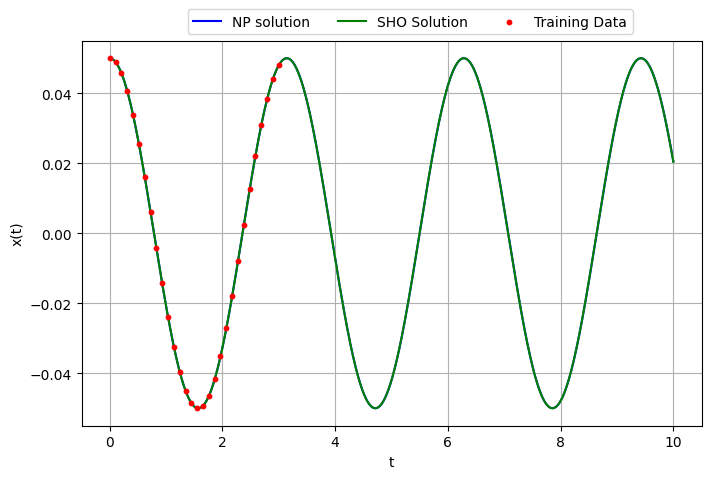

In [53]:
# Parameters and initial conditions
X0 = [0.05, 0]
w0 = 2


# time domain
ti = 0
tf = 10
N  = 10_000

t = torch.linspace(ti, tf, N).view(-1,1)

# Numerical Solution

def ODE(X, t):
    dXdt = [X[1], -(w0**2)*np.sin(X[0])]
    return dXdt

def ODE_2(X, t):
    dXdt = [X[1], -(w0**2)*X[0]]
    return dXdt

# Nonlinear Pendulum Solution
solution = torch.from_numpy(odeint(ODE, X0, t.numpy().flatten())).view(-1,2)
x1       = solution[:,0]
x2       = solution[:,1]
x1_max   = torch.abs(x1).max().item()
x2_max   = torch.abs(x2).max().item()

# Harmonic Oscillator Solution
solution2 = torch.from_numpy(odeint(ODE_2, X0, t.numpy().flatten())).view(-1,2)
y1        = solution2[:,0]
y2        = solution2[:,1]
y1_max    = torch.abs(x1).max().item()
y2_max    = torch.abs(x2).max().item()

# solution.dtype = np.double

# Pick points for training
N_training = 30
t_data     = torch.linspace(ti, tf*0.3, N_training).view(-1,1)
training_data = solution[torch.searchsorted(t.flatten(), t_data.flatten()), :]
x1_data       = training_data[:,0].view(-1,1)
x2_data       = training_data[:,1].view(-1,1)

# Pick a few points for validation
N_validation = 200
t_val        = torch.linspace(ti*1.1, tf, N_validation).view(-1,1)
validation_data = solution[torch.searchsorted(t.flatten(), t_val.flatten()), :]
x1_val          = validation_data[:,0].view(-1,1)
x2_val          = validation_data[:,1].view(-1,1)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(t, x1, label='NP solution', color='blue', zorder=1)
ax.plot(t, y1, label="SHO Solution", color='green', zorder=2)
ax.scatter(t_data, x1_data, color='red', label='Training Data', s=10, zorder=3)
ax.set_xlabel('t')
ax.set_ylabel('x(t)')
plt.legend(ncol=3, bbox_to_anchor=(0.9, 1.1))
plt.grid()
plt.show()

## PINN

In [ ]:
def plot_result(
    i, epochs, t, x, y,
    t_data, x_data,
    p, tc,
    training_loss, validation_loss, mse
    ):
    xmax = torch.abs(x).max().item()
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    
    axes[0].grid()
    axes[0].plot(t, x, color="red", linewidth=1, alpha=1,linestyle='--',label="NP Solution", zorder=0)
    axes[0].plot(t, y, color="gray", linewidth=2, alpha=1,linestyle='--',label="SHO Solution", zorder=0)
    axes[0].plot(t, p, color="blue", linewidth=2, alpha=0.8, label="PINN prediction", zorder=1)
    axes[0].scatter(t_data, x_data, s=15, color="red", alpha=0.4, label='Training data', zorder=2)
    axes[0].scatter(tc, -0*torch.ones_like(tc), s=10, color="green", alpha=0.4,label='Collocation points', zorder=2)
    axes[0].set_ylim(-1.05*xmax, 1.05*xmax)
    axes[0].set_ylabel('x(t)',fontsize="x-large")
    axes[0].set_xlabel('t',fontsize="x-large")
    axes[0].legend()
    
    axes[1].grid()
    axes[1].plot(range(i+1), training_loss, label='Training Loss', color='red', linewidth=2, zorder=1)
    axes[1].plot(range(i+1), validation_loss, label='Validation Loss', color='blue', linewidth=1.5, zorder=2, alpha=0.6)
    axes[1].plot(range(i+1), mse, label='MSE', color='green', linewidth=2, zorder=3, alpha=0.5)
    axes[1].set_yscale('log')
    axes[1].set_xlim(0, epochs)
    axes[1].set_ylim(1e-7, 1e2)
    axes[1].set_xlabel('Epochs', fontsize="x-large")
    axes[1].set_ylabel('Loss', fontsize="x-large")
    axes[1].set_title(f'MSE = {mse[-1]:.3e}', fontsize="x-large")
    axes[1].legend()
    
    fig.suptitle(f"SHO data with NP ODE with x_0={X0[0]} and x'_0={X0[1]} \n Epoch {i}", fontsize="x-large")

    plt.tight_layout()
    plt.axis("on")

In [ ]:
# Define Neural Network Structure

class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        
        self.scale = lambda t: (t - ti)/(tf - ti)
        self.fcs   = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN),activation()])
        self.fch   = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_HIDDEN, N_HIDDEN), activation()]) for _ in range(N_LAYERS-1)])
        self.fce   = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.scale(x)
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [ ]:
learning_rate = 5e-4
epochs        = 50_000 + 1
w_data        = 1
w_derivative  = 0.5
w_ode         = 0.1
w_energy      = 0
N_phys        = 200

N_layers = 3
N_nodes  = 32

In [ ]:
# Define the samle locations for training data
t_training  = t_data.clone().requires_grad_(True)

# Define the sample locations for validation
t_validation = t_val.clone().requires_grad_(True)

# Define the sample locations for physics-informed training
t_physics = torch.linspace(ti, tf, N_phys).view(-1,1).requires_grad_(True)


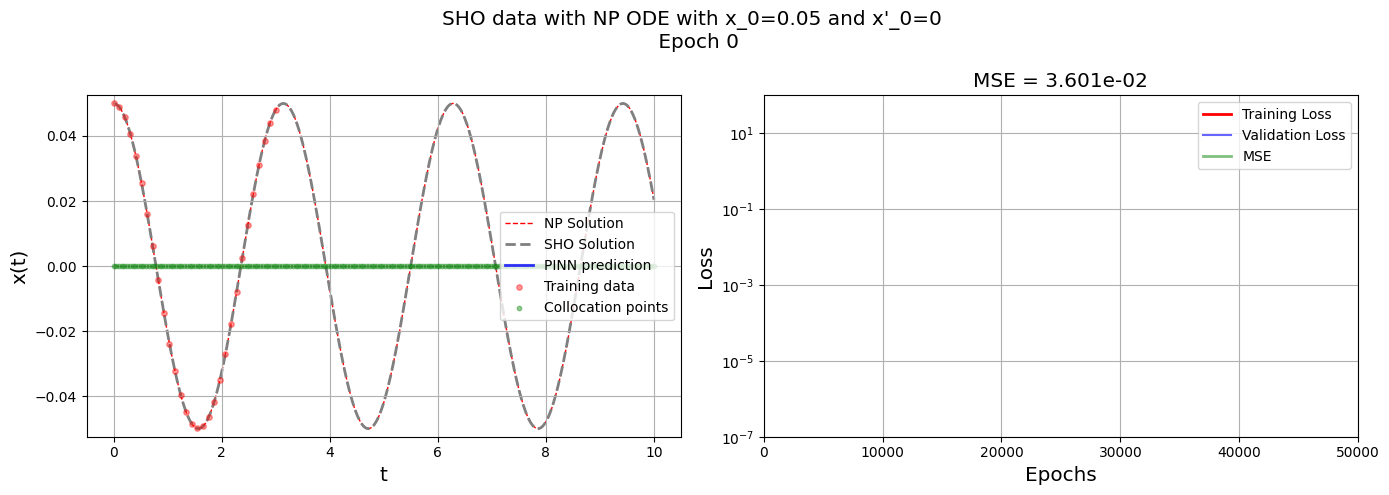

KeyboardInterrupt: 

In [ ]:
# PINN
PINN = FCN(1, 1, N_nodes, N_layers)

# Uses the Adam optimizer
optimizer = torch.optim.Adam(PINN.parameters(), lr = learning_rate)

# Number of training steps

ode_loss_history = []
data_loss_history = []
derivative_loss_history = []
energy_loss_history = []
loss_history = []
mse_history = []
ode_validation_loss_history = []
data_validation_loss_history = []
derivative_validation_loss_history = []
energy_validation_loss_history = []
validation_loss_history = []

for i in range(epochs):
    # ===
    # Training
    # ===
    
    PINN.train()
    optimizer.zero_grad()
    
    # Compute data loss .........................
    y  = PINN(t_training)
    data_loss = torch.mean((y - x1_data)**2)
    
    # Compute derivative loss .........................
    dy = torch.autograd.grad(y, t_training, torch.ones_like(y), create_graph=True)[0]
    derivative_loss = torch.mean((dy - x2_data)**2)
    
    # Compute the ODE loss .........................
    z   = PINN(t_physics)
    dz  = torch.autograd.grad(z, t_physics, torch.ones_like(z), create_graph=True)[0]
    d2z = torch.autograd.grad(dz, t_physics, torch.ones_like(dz), create_graph=True)[0]
    ode = d2z + (w0**2)*z
    ode_loss = torch.mean(ode**2)
    
    # Compute total loss
    loss = (w_data*data_loss + w_derivative*derivative_loss + w_ode*ode_loss)/X0[0]
    
    # Backpropagate the loss and update weights
    loss.backward()
    optimizer.step()
    
    # ===
    # Validation
    # ===
    PINN.eval()

    v = PINN(t_validation)
    dv = torch.autograd.grad(v, t_validation, torch.ones_like(v), create_graph=True)[0]
    d2v = torch.autograd.grad(dv, t_validation, torch.ones_like(dv), create_graph=True)[0]
    
    data_loss_val       = torch.mean((v - x1_val)**2)
    derivative_loss_val = torch.mean((dv - x2_val)**2)
    ode_loss_val        = torch.mean((d2v + (w0**2)*v)**2)

    loss_val = w_data*data_loss_val + w_derivative*derivative_loss_val + w_ode*ode_loss_val
    # ===
    # Saving training information
    # ===
    
    data_loss_history.append(w_data*data_loss.item())
    derivative_loss_history.append(w_derivative*derivative_loss.item())
    ode_loss_history.append(w_ode*ode_loss.item())
    loss_history.append(loss.item())
    
    data_validation_loss_history.append(w_data*data_loss_val.item())
    derivative_validation_loss_history.append(w_derivative*derivative_loss_val.item())
    ode_validation_loss_history.append(w_ode*ode_loss_val.item())
    validation_loss_history.append(loss_val.item())
    
    p   = PINN(t).detach()
    mse = torch.mean((p - x1.view(-1,1))**2).item()
    mse_history.append(mse)
    # ===
    # Plotting
    # ===
    
    if (i % 1_000) == 0: 
        plot_result(
            i, epochs, t.detach(), x1.detach(), y1.detach(),
            t_data.detach(), x1_data.detach(),
            p, t_physics.detach(),
            data_loss_history, data_validation_loss_history, mse_history
        )
        
        if i == (epochs-1):
            plt.savefig(f"plots/NP_data_SHO_ODE_x0_{X0[0]}.png", dpi=300, bbox_inches='tight')
            plt.show()
        elif (i % 5_000) == 0:
            plt.show()
        else: 
            plt.close("all")

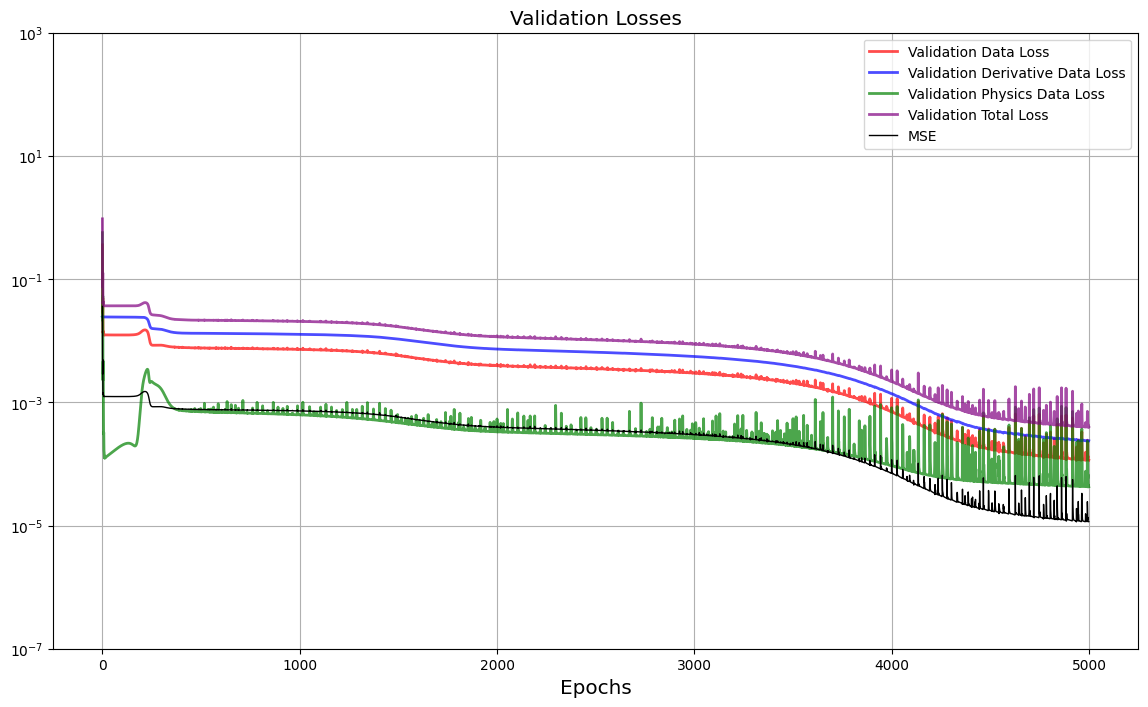

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))
M = 10
n = len(data_validation_loss_history[0:-1:M])
if w_data > 0:
    ax.plot(range(n), data_validation_loss_history[0:-1:M], label='Validation Data Loss', color='red', linewidth=2, zorder=2, alpha=0.7)
if w_derivative > 0:
    ax.plot(range(n), derivative_validation_loss_history[0:-1:M], label='Validation Derivative Data Loss', color='blue', linewidth=2, zorder=2, alpha=0.7)
if w_ode > 0:
    ax.plot(range(n), ode_validation_loss_history[0:-1:M], label='Validation Physics Data Loss', color='green', linewidth=2, zorder=2, alpha=0.7)

    
ax.plot(range(n), validation_loss_history[0:-1:M], label='Validation Total Loss', color='purple', linewidth=2, zorder=2, alpha=0.7)
ax.plot(range(n), mse_history[0:-1:M], label='MSE', color='black', linewidth=1, zorder=5, alpha=1)
ax.set_xlabel('Epochs', fontsize="x-large")
ax.legend()
ax.grid()
ax.set_yscale('log')
ax.set_title('Validation Losses', fontsize="x-large")
ax.set_ylim(1e-7, 1e3)
plt.show()

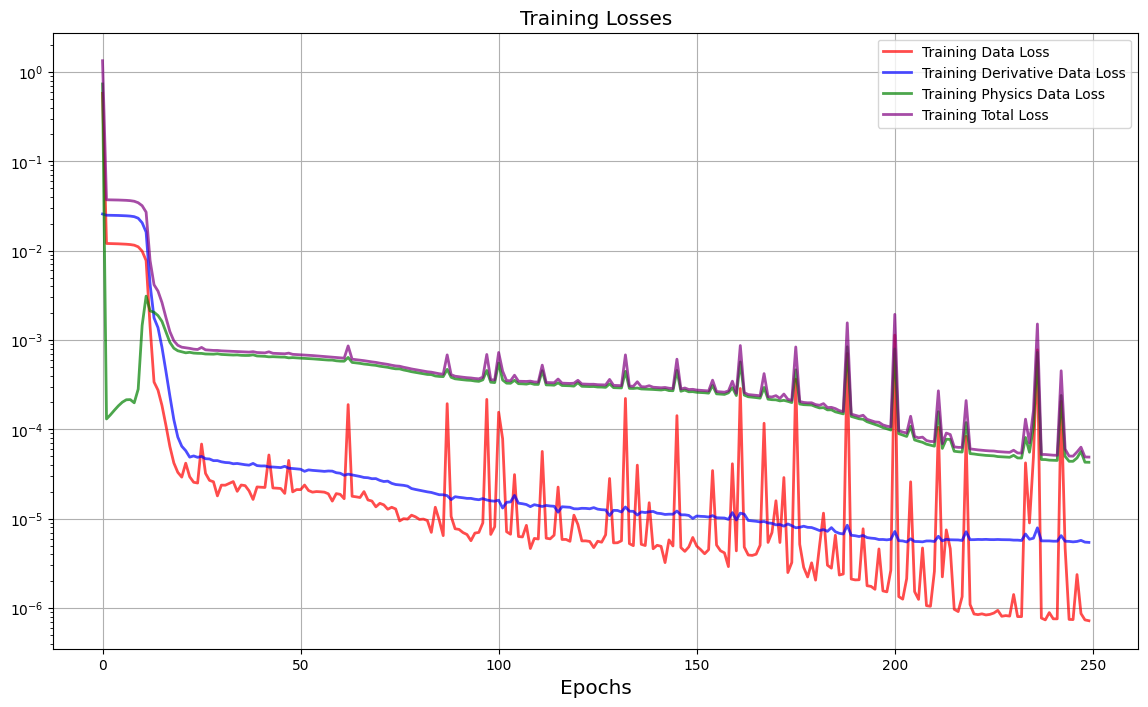

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))
M = 200
n = len(data_loss_history[0:-1:M])
if w_data > 0:
    ax.plot(range(n), data_loss_history[0:-1:M], label='Training Data Loss', color='red', linewidth=2, zorder=2, alpha=0.7)
if w_derivative > 0:
    ax.plot(range(n), derivative_loss_history[0:-1:M], label='Training Derivative Data Loss', color='blue', linewidth=2, zorder=2, alpha=0.7)
if w_ode > 0:
    ax.plot(range(n), ode_loss_history[0:-1:M], label='Training Physics Data Loss', color='green', linewidth=2, zorder=2, alpha=0.7)

ax.plot(range(n), loss_history[0:-1:M], label='Training Total Loss', color='purple', linewidth=2, zorder=2, alpha=0.7)

ax.set_xlabel('Epochs', fontsize="x-large")
ax.legend()
ax.grid()
ax.set_yscale('log')
ax.set_title('Training Losses', fontsize="x-large")
plt.show()

In [ ]:
MSE_data = np.array(mse_history)
np.save(f"data/mse_SHO_ODE_NP_DATA_{X0[0]:.3f}.npy", MSE_data)